# This is the current setup.ipynb for the ikt524 project at UIA Grimstad. This file sets up the YoloV11 model step by step to streamline the setup process. It is recomended to run 1 cell at a time.

In [29]:
print("Hello world! hehe")

Hello world! hehe



## **Step 0**
The code block above simply tests the external server, make sure to connect to the external server in order to use the fe.uia.no server for all steps below and verify that the print works

In [30]:
# 1) Environment info
import sys, platform, subprocess
print("Python:", sys.version)
print("Executable:", sys.executable)
print("Platform:", platform.platform())
print("\nsite module output:\n")
subprocess.run([sys.executable, "-m", "site"])



Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Executable: /usr/bin/python
Platform: Linux-6.8.0-64-generic-x86_64-with-glibc2.35

site module output:

sys.path = [
    '/home/kristoffel',
    '/usr/lib/python310.zip',
    '/usr/lib/python3.10',
    '/usr/lib/python3.10/lib-dynload',
    '/home/kristoffel/.local/lib/python3.10/site-packages',
    '/usr/local/lib/python3.10/dist-packages',
    '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.1+gitunknown-py3.10-linux-x86_64.egg',
    '/usr/lib/python3/dist-packages',
]
USER_BASE: '/home/kristoffel/.local' (exists)
USER_SITE: '/home/kristoffel/.local/lib/python3.10/site-packages' (exists)
ENABLE_USER_SITE: True


CompletedProcess(args=['/usr/bin/python', '-m', 'site'], returncode=0)

## **Step 1**
This cell displays the enviroment info on the external server

In [31]:
# 2) Install/upgrade ultralytics on external server
import sys
print("Installing/Upgrading ultralytics on external server…")

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --user -U ultralytics



Installing/Upgrading ultralytics on external server…
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## **Step 2**
Updating pip and installing ultralytics

In [32]:
# 3) Verify ultralytics & torch, detect device
import torch
from ultralytics import YOLO

print("Ultralytics import OK.")
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    try:
        print("Default device:", torch.cuda.get_device_name(0))
    except Exception as e:
        print("(device name unavailable)")
else:
    print("Using CPU")


Ultralytics import OK.
Torch: 2.2.0a0+81ea7a4
CUDA available: True
CUDA device count: 1
Default device: Tesla V100-SXM3-32GB


## **Step 3**
Verify and check the ultralytics, torch and jupyterlab settings, should correspond with the values set on fe.uia.no

# Testing the YoloV11 model

In [33]:
# 4) Helper functions
import os, shutil, pathlib


def weight_stem(task="detect", family=None, size=None):
    family = family or globals().get("MODEL_FAMILY", "yolo11")
    size = size or globals().get("MODEL_SIZE", "n")
    if task == "segment":
        return f"{family}{size}-seg.pt"
    elif task == "pose":
        return f"{family}{size}-pose.pt"
    else:
        return f"{family}{size}.pt"


def weight_urls(fname: str, release="v8.3.0", family=None):
    family = family or globals().get("MODEL_FAMILY", "yolo11")
    return [
        f"https://github.com/ultralytics/assets/releases/download/{release}/{fname}",
        f"https://huggingface.co/ultralytics/{family}/resolve/main/{fname}",
    ]


def ok_file(path: str) -> bool:
    p = pathlib.Path(path)
    if not p.exists() or p.stat().st_size < 1_000_000:  # >1MB sanity check
        return False
    try:
        with open(path, "rb") as f:
            head = f.read(32)
        if head[:5].lower() == b"<html":
            return False
    except Exception:
        return False
    return True


def ensure_weight(task="detect", family=None, size=None, prefer_local="") -> str:
    family = family or globals().get("MODEL_FAMILY", "yolo11")
    size = size or globals().get("MODEL_SIZE", "n")
    os.makedirs("weights", exist_ok=True)
    fname = weight_stem(task, family, size)

    if prefer_local:
        if ok_file(prefer_local):
            print(f"✅ Using local weight: {prefer_local}")
            return prefer_local
        else:
            print(f"⚠️ Local weight invalid or missing: {prefer_local}")

    dest = os.path.join("weights", fname)

    # Reuse valid file if present
    if ok_file(dest):
        print(f"✅ Found existing weight: {dest}")
        return dest

    # Try downloading from mirrors
    for url in weight_urls(fname, family=family):
        print(f"⬇️  Trying: {url}")
        if shutil.which("curl"):
            cmd = f'curl -L --fail --retry 3 --retry-delay 2 -o "{dest}" "{url}"'
        elif shutil.which("wget"):
            cmd = f'wget -O "{dest}" "{url}"'
        else:
            print("❌ Neither curl nor wget available")
            return ""
        rc = os.system(cmd)
        if rc == 0 and ok_file(dest):
            print(f"✅ Downloaded OK: {dest} ({os.path.getsize(dest)} bytes)")
            return dest
        else:
            try:
                os.remove(dest)
            except:
                pass
            print("⚠️ Download failed or invalid file")

    print(
        "❌ Could not obtain weights automatically")
    return ""


# **Helper function for the tests**

Helper function to for the upcoming tests

✅ Found existing weight: weights/yolo11n.pt
Loaded detection model: weights/yolo11n.pt
Running detection on sample image…

Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /home/kristoffel/bus.jpg: 640x480 4 persons, 1 bus, 38.9ms
Speed: 2.1ms preprocess, 38.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)
Inference done in 0.07s on device=cpu


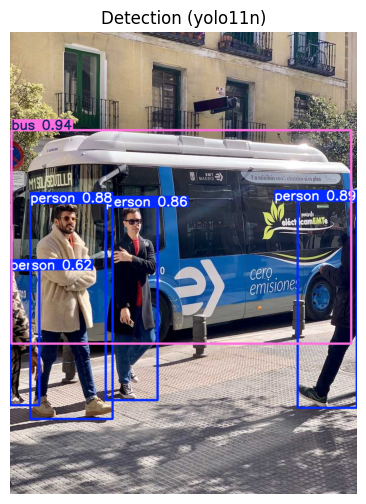


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /home/kristoffel/bus.jpg: 640x480 4 persons, 1 bus, 49.5ms
Speed: 2.0ms preprocess, 49.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /home/kristoffel/runs/verify_20250922_091326/detect
Saved annotated outputs under: runs/verify_20250922_091326/detect


In [34]:
# 5) Detection sanity test
import time
import matplotlib.pyplot as plt
from datetime import datetime
from ultralytics import YOLO

FAMILY = globals().get("MODEL_FAMILY", "yolo11")
SIZE = globals().get("MODEL_SIZE", "n")
DEVICE = globals().get("DEVICE", "cpu")
PREFER_LOCAL = globals().get("WEIGHT_LOCAL_DET", "")

det_path = ensure_weight(task="detect", family=FAMILY, size=SIZE, prefer_local=PREFER_LOCAL)
assert det_path, "No detection weights available. Upload the .pt file or allow downloads."

model_det = YOLO(det_path)
print(f"Loaded detection model: {det_path}")

img_url = "https://ultralytics.com/images/bus.jpg"
print("Running detection on sample image…")
t0 = time.time()
res = model_det(img_url, device=DEVICE)[0]
dt = time.time() - t0
print(f"Inference done in {dt:.2f}s on device={DEVICE}")

img = res.plot()[..., ::-1]  # BGR -> RGB
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f"Detection ({FAMILY}{SIZE})")
plt.show()

stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
outdir = f"runs/verify_{stamp}"
_ = model_det.predict(img_url, device=DEVICE, save=True, project=outdir, name="detect")
print(f"Saved annotated outputs under: {outdir}/detect")


## **Regular YoloV11 test**

✅ Found existing weight: weights/yolo11n-seg.pt
Loaded segmentation model: weights/yolo11n-seg.pt

Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /home/kristoffel/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 54.5ms
Speed: 4.1ms preprocess, 54.5ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 480)


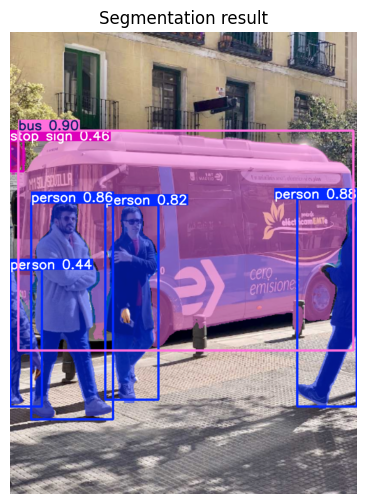

In [35]:
# 6) Segmentation sanity test (optional)
if globals().get("RUN_SEGMENT", True):
    import matplotlib.pyplot as plt
    from ultralytics import YOLO

    FAMILY = globals().get("MODEL_FAMILY", "yolo11")
    SIZE = globals().get("MODEL_SIZE", "n")
    DEVICE = globals().get("DEVICE", "cpu")
    PREFER_LOCAL_SEG = globals().get("WEIGHT_LOCAL_SEG", "")

    seg_path = ensure_weight(task="segment", family=FAMILY, size=SIZE, prefer_local=PREFER_LOCAL_SEG)
    if seg_path:
        model_seg = YOLO(seg_path)
        print(f"Loaded segmentation model: {seg_path}")
        img_url = "https://ultralytics.com/images/bus.jpg"
        res = model_seg(img_url, device=DEVICE, task="segment")[0]
        img = res.plot()[..., ::-1]
        plt.figure(figsize=(10, 6));
        plt.imshow(img);
        plt.axis("off");
        plt.title("Segmentation result");
        plt.show()
    else:
        print("Segmentation weights not available.")


## **Segmentation YoloV11 test**